In [1]:
# !pip install tensorflow
# !pip install gym
# !pip install keras
# !pip install keras-rl2
# !pip install pygame
! pip uninstall tensorflow -y
! pip install tensorflow-macos==2.8.0

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
ERROR: Could not find a version that satisfies the requirement tensorflow-macos==2.8.0 (from versions: 2.9.0, 2.9.1, 2.9.2, 2.10.0, 2.11.0)
ERROR: No matching distribution found for tensorflow-macos==2.8.0


In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.animation
from IPython.display import display, clear_output
import random
import pygame

In [3]:
code2action = {
    0:np.array([0, 0, 0, 0]),
    1:np.array([0, 0, 1, 0]),
    2:np.array([0, 0, -1, 0]),
    3:np.array([0, 0, 0, 1]),
    4:np.array([0, 0, 0, -1]),
    5:np.array([0, 0, 1, 1]),
    6:np.array([0, 0, 1, -1]),
    7:np.array([0, 0, -1, 1]),
    8:np.array([0, 0, -1, -1])
}

class ShrinkingCircleEnv(Env):
    width = height = d = 10
    time = 60
    terminated_penalty = 1
    window = None
    window_size = 512
    clock = None
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 15}
    
    def __init__(self):
        self.action_space = Discrete(9)
        self.bounds = np.array([self.height, self.width, self.height, self.width]) - 1
        self.observation_space = Discrete(self.d**4)
        
        
        self.state = (np.random.random_sample(size=4)*self.bounds).astype(int)
        
        self.circle_radius = 0
        
        self.timestamp = self.time
        
        # for rendering
        self.log_circles = []
        self.log_hero = []

        
        
    def get_reward(self):
        circle, hero = self.state[:2], self.state[2:]
        return - np.linalg.norm(hero - circle)
        
    def step(self, action):
        new_state = self.state + code2action[action]
        terminated = not ((0 <= new_state).all() and (new_state < self.bounds).all())
        
        self.timestamp -= 1 
        self.truncated = self.timestamp<=0
        
        reward = self.get_reward()
        
        # move center of circle with probability 0.2
        if np.random.binomial(1, 0.2):
            self.state = np.hstack((
                new_state[:2] + random.choice(list(code2action.values()))[2:],
                new_state[2:]
            ))
        
        # to stay on the playing field
        self.state = np.clip(self.state, np.zeros(4), self.bounds)
            
        info = {}
        return self.state, reward, self.truncated, info
    
    def render(self, mode):
        self.render_mode = mode
        circle, hero = self.state[:2], self.state[2:]
        self.log_circles.append(circle)
        self.log_hero.append(hero)
        
        return self._render_frame()
    
    # inspired by https://www.gymlibrary.dev/content/environment_creation/
    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()
        
        
        circle, hero = self.state[:2], self.state[2:]
        
        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.d
        )  # The size of a single grid square in pixels

        # First we draw the hero
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * hero,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the circle
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (circle + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.d + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )
        
        font = pygame.font.Font(None, 25)
        text = font.render(f"Time remaining: {str(self.timestamp)}", True,(0, 0, 128))
        text_rect = text.get_rect(center=(self.window_size/6, self.window_size/15))
        
        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            self.window.blit(text, text_rect)
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
        
    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()
    
    def reset(self):
        
        self.state = (np.random.random_sample(size=4)*self.bounds).astype(int)
        self.circle_radius = 0 #min(self.height, self.width)
        self.timestamp = self.time
        
        self.log_circles = []
        self.log_hero = []
        self.window = None
        self.clock = None
        return self.state
    

In [4]:
env = ShrinkingCircleEnv()

### Let's learn the model

In [5]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [6]:
def state2code(state):
    return int(np.sum([position*10**i for i, position in enumerate(state)]))


In [7]:
import time

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

hist_reward = []
def evaluate(env, q_table, nb_episodes=100, render=False):
    """Evaluate agent's performance after Q-learning"""
    reward_log = []
    for _ in range(nb_episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            if render:
                env.render(mode='human')
            
            action = np.argmax(q_table[state2code(state)])
            state, reward, done, info = env.step(action)
            episode_reward += reward

        reward_log.append(episode_reward)
    return np.mean(np.array(reward_log))

# For plotting metrics
all_epochs = []
all_penalties = []
start_time = time.time()
for i in range(30):
    for i in range(1, 500):
        state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state2code(state)]) # Exploit learned values

            next_state, reward, done, info = env.step(action) 

            old_value = q_table[state2code(state), action]
            next_max = np.max(q_table[state2code(next_state)])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state2code(state), action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        if i % 100 == 0:
            #clear_output(wait=True)
            print(f"Episode: {i}")
    

    mean_reward = evaluate(env, q_table)
    print("--- %s seconds ---" % (time.time() - start_time))
    hist_reward.append([i,time.time() - start_time, mean_reward])

print("Training finished.\n")

Episode: 100
Episode: 200
Episode: 300
Episode: 400
--- 4.433883905410767 seconds ---
Episode: 100
Episode: 200
Episode: 300
Episode: 400
--- 8.917109966278076 seconds ---
Episode: 100
Episode: 200
Episode: 300
Episode: 400
--- 13.392775774002075 seconds ---
Training finished.



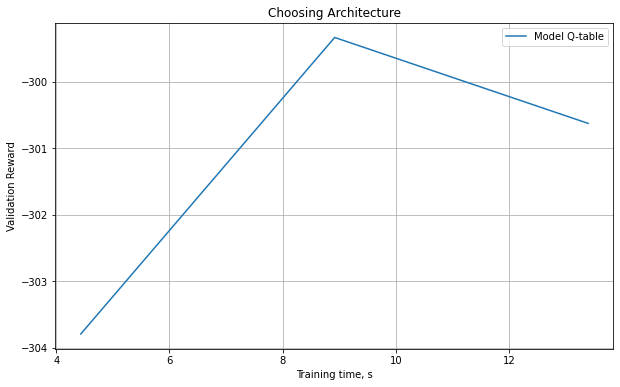

In [8]:
x_qt = [x[1] for x in hist_reward]
y_qt = [x[2] for x in hist_reward]
plt.figure(figsize=(10,6))
for i, x, y in zip(['Q-table'], [ x_qt], [ y_qt]):
    
    
    plt.plot(x, y, label=f'Model {i}')
    plt.xlabel('Training time, s')
    plt.ylabel('Validation Reward')
    plt.title('Choosing Architecture')
plt.legend()
plt.grid()